In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

pd.set_option('display.max_colwidth', 200)
# specify GPU
device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/wholething.pkl")
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df.head()

,symbol,cik,form,access_number,filed_date,accepted_date,report_url,filing_url,string,texts,lens,pct_change1,pct_change2,beta1,beta2,mkt_excess1,mkt_excess2
0,NICK,1000045,8-K,0001193125-19-024617,2019-02-01,2019-02-01 06:31:07,https://www.sec.gov/Archives/edgar/data/1000045/000119312519024617/d675768d8k.htm,https://www.sec.gov/Archives/edgar/data/1000045/000119312519024617/0001193125-19-024617-index.html,"8-K 1 d675768d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","Item 2.02\nResults of Operations and Financial Condition\nOn February 1, 2019 Nicholas Financial, Inc. (the “Company”) issued a press release announcing the Company’s financial results for its qua...",182,0.039772,0.018824,0.1235,0.12100,0.039502,0.017531
1,MFIN,1000209,8-K,0001193125-19-004285,2019-01-08,2019-01-08 09:10:35,https://www.sec.gov/Archives/edgar/data/1000209/000119312519004285/d685338d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519004285/0001193125-19-004285-index.html,"8-K 1 d685338d8k.htm 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXCHANGE...","Item 2.02 Results of Operations and Financial Condition.\nItem 7.01 Regulation FD Disclosure\nOn January 7, 2019, Medallion Bank (the “Bank”), a wholly owned subsidiary of Medallion Financial Corp...",711,0.005894,0.019647,0.9098,0.91085,-0.003435,0.005013
2,MFIN,1000209,8-K,0001193125-19-007413,2019-01-11,2019-01-11 16:32:03,https://www.sec.gov/Archives/edgar/data/1000209/000119312519007413/d682501d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519007413/0001193125-19-007413-index.html,"8-K 1 d682501d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","ITEM 1.01.\nENTRY INTO A MATERIAL DEFINITIVE AGREEMENT.\nOn January 11, 2019, Taxi Medallion Loan Trust III (the “Trust”), an indirect unconsolidated wholly-owned subsidiary of Medallion Financial...",261,-0.019268,-0.019268,0.8742,0.87420,-0.013888,-0.013888
3,MFIN,1000209,8-K,0001193125-19-024926,2019-02-01,2019-02-01 08:50:35,https://www.sec.gov/Archives/edgar/data/1000209/000119312519024926/d671008d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519024926/0001193125-19-024926-index.html,"8-K 1 d671008d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","ITEM 1.01.\nENTRY INTO A MATERIAL DEFINITIVE AGREEMENT.\nOn January 31, 2019, Freshstart Venture Capital Corp. (“Freshstart”), a wholly-owned subsidiary of Medallion Financial Corp. (the “Company”...",257,0.077505,0.035918,0.8901,0.88485,0.076161,0.027620
4,MFIN,1000209,8-K,0001193125-19-047009,2019-02-21,2019-02-21 16:13:02,https://www.sec.gov/Archives/edgar/data/1000209/000119312519047009/d711389d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519047009/0001193125-19-047009-index.html,"8-K 1 d711389d8k.htm 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXCHANGE...","ITEM 1.01.\nENTRY INTO A MATERIAL DEFINITIVE AGREEMENT.\nOn February 15, 2019, Freshstart Venture Capital Corp. (“Freshstart”), a wholly-owned subsidiary of Medallion Financial Corp. (the “Company...",257,0.076013,0.076013,0.9225,0.92250,0.070040,0.070040


In [22]:
df = df[:5000]

In [23]:
def label1(row):
    if row["pct_change1"] > row["beta1"]*row["mkt_excess1"]:
        return "pos"
    else:
        return "neg"

In [24]:
df["label1"] = df.apply(label1, axis = 1)

In [25]:
def label2(row):
    if row["pct_change2"] > row["beta2"]*row["mkt_excess2"]:
        return "pos"
    else:
        return "neg"

In [26]:
df["label2"] = df.apply(label2, axis = 1)

In [27]:
def label4(row):
    if row["pct_change2"] > row["beta2"]*row["mkt_excess2"] + 0.005:
        return "positive"
    elif row["pct_change2"] < row["beta2"]*row["mkt_excess2"] - 0.005:
        return "negative"
    else:
        return "neutral"

In [28]:
df["label4"] = df.apply(label4, axis = 1)

In [29]:
le = preprocessing.LabelEncoder()
le.fit(df['label2'])

LabelEncoder()

In [30]:
le.classes_

array(['neg', 'pos'], dtype=object)

In [31]:
le.transform(['neg', 'pos'])

array([0, 1])

In [32]:
y = le.transform(df['label2'])

In [33]:
def extract_text(x):
  items = x.split('\n')

  for i in items[1:]:
    if len(i.split()) >= 20:
      break

  return i.lower()

In [34]:
df['clean_text'] = df['texts'].apply(lambda x: extract_text(x))
df.head()

,symbol,cik,form,access_number,filed_date,accepted_date,report_url,filing_url,string,texts,lens,pct_change1,pct_change2,beta1,beta2,mkt_excess1,mkt_excess2,label1,label2,label4,clean_text
0,NICK,1000045,8-K,0001193125-19-024617,2019-02-01,2019-02-01 06:31:07,https://www.sec.gov/Archives/edgar/data/1000045/000119312519024617/d675768d8k.htm,https://www.sec.gov/Archives/edgar/data/1000045/000119312519024617/0001193125-19-024617-index.html,"8-K 1 d675768d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","Item 2.02\nResults of Operations and Financial Condition\nOn February 1, 2019 Nicholas Financial, Inc. (the “Company”) issued a press release announcing the Company’s financial results for its qua...",182,0.039772,0.018824,0.1235,0.12100,0.039502,0.017531,pos,pos,positive,"on february 1, 2019 nicholas financial, inc. (the “company”) issued a press release announcing the company’s financial results for its quarter ended december 31, 2018. a copy of this press release..."
1,MFIN,1000209,8-K,0001193125-19-004285,2019-01-08,2019-01-08 09:10:35,https://www.sec.gov/Archives/edgar/data/1000209/000119312519004285/d685338d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519004285/0001193125-19-004285-index.html,"8-K 1 d685338d8k.htm 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXCHANGE...","Item 2.02 Results of Operations and Financial Condition.\nItem 7.01 Regulation FD Disclosure\nOn January 7, 2019, Medallion Bank (the “Bank”), a wholly owned subsidiary of Medallion Financial Corp...",711,0.005894,0.019647,0.9098,0.91085,-0.003435,0.005013,pos,pos,positive,"on january 7, 2019, medallion bank (the “bank”), a wholly owned subsidiary of medallion financial corp. (the “company”), filed a registration statement on form 10 relating to an offering of the ba..."
2,MFIN,1000209,8-K,0001193125-19-007413,2019-01-11,2019-01-11 16:32:03,https://www.sec.gov/Archives/edgar/data/1000209/000119312519007413/d682501d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519007413/0001193125-19-007413-index.html,"8-K 1 d682501d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","ITEM 1.01.\nENTRY INTO A MATERIAL DEFINITIVE AGREEMENT.\nOn January 11, 2019, Taxi Medallion Loan Trust III (the “Trust”), an indirect unconsolidated wholly-owned subsidiary of Medallion Financial...",261,-0.019268,-0.019268,0.8742,0.87420,-0.013888,-0.013888,neg,neg,negative,"on january 11, 2019, taxi medallion loan trust iii (the “trust”), an indirect unconsolidated wholly-owned subsidiary of medallion financial corp., (the “company”) entered into an amendment (the “a..."
3,MFIN,1000209,8-K,0001193125-19-024926,2019-02-01,2019-02-01 08:50:35,https://www.sec.gov/Archives/edgar/data/1000209/000119312519024926/d671008d8k.htm,https://www.sec.gov/Archives/edgar/data/1000209/000119312519024926/0001193125-19-024926-index.html,"8-K 1 d671008d8k.htm FORM 8-K\n UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, DC 20549\n FORM 8-K\n CURRENT REPORT\nPURSUANT TO SECTION 13 OR 15(d)\nOF THE SECURITIES EXC...","ITEM 1.01.\nENTRY INTO A MATERIAL DEFINITIVE AGREEMENT.\nOn January 31, 2019, Freshstart Venture Capital Corp. (“Freshstart”), a wholly-owned subsidiary of Medallion Financial Corp. (the “Company”...",257,0.077505,0.035918,0.8901,0.88485,0.076161,0.027620,pos,pos,positive,"on january 31, 2019, freshstart venture capital corp. (“freshstart”), a wholly-owned subsidiary of medallion financial corp. (the “company”), entered into amendments (the “amendments”) which amend..."
4,MFIN,1000209,8-K,0001193125-19-047009,2019-02-21,2019-02-21 16:13:02,https://www.sec.gov/Archives/edgar/data/1000209/0001

In [35]:
# split train dataset into train and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(df['clean_text'], y, 
                                                                    random_state= 42, 
                                                                    test_size=0.2, 
                                                                    stratify=y)

In [36]:
# import the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

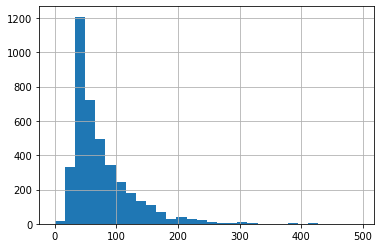

In [37]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [38]:
s = np.array(seq_len)

np.quantile(s, 0.92)

149.08000000000038

In [39]:
maxlen = 150

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = maxlen,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = maxlen,
    padding='max_length',
    truncation=True
)

In [41]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [42]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [43]:
len(tokens_train['input_ids'])

4000

In [44]:
len(tokens_train['attention_mask'])

4000

In [45]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Model Building

In [46]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
for param in bert.base_model.parameters():
    param.requires_grad = False

In [48]:
class BERT_Classification(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Classification, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)


      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [49]:
# pass the pre-trained BERT to our define architecture
model = BERT_Classification(bert)

# push the model to GPU
model = model.to(device)

In [50]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-4)

In [51]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.17855038 0.86843248]


In [53]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function and pass class weights in it
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [56]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [57]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 100 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [58]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch   100  of    125.

Evaluating...

Training Loss: 0.705
Validation Loss: 0.696

 Epoch 2 / 5
  Batch   100  of    125.

Evaluating...

Training Loss: 0.699
Validation Loss: 0.698

 Epoch 3 / 5
  Batch   100  of    125.

Evaluating...

Training Loss: 0.696
Validation Loss: 0.697

 Epoch 4 / 5
  Batch   100  of    125.

Evaluating...

Training Loss: 0.698
Validation Loss: 0.693

 Epoch 5 / 5
  Batch   100  of    125.

Evaluating...

Training Loss: 0.695
Validation Loss: 0.699


In [59]:
# load weights of best saved model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [60]:
valid_loss, preds = evaluate()


Evaluating...


In [61]:
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.43      0.47      0.45       424
           1       0.58      0.54      0.56       576

    accuracy                           0.51      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.51      0.51      0.51      1000

